In [ ]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from jupyterthemes import jtplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import itertools
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta




In [2]:
train_1 = pd.read_csv('train_1.csv') 

In [3]:
def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org', url)
    if res:
        return res[0][0:2]
    return 'na'

def data_per_date(data):

    data1 = data.copy()
    temp = data1.Page.str.rsplit("_", expand=True, n=3)

    data1['lang'] = data1.Page.map(find_language)
    data1['Page'] = temp[0]
    data1['Type_of_traffic'] = temp[2]
    data1['Agent'] = temp[3]

    data_melted = pd.melt(data1, id_vars=['Page', 'Type_of_traffic', 'Agent', 'lang'],
                          var_name='Date', value_name='count')
    data_melted['Date'] = data_melted['Date'].astype('datetime64[ns]')

    return data_melted
def find_page(data_melted, page_name):

    my_page = data_melted[data_melted.Page == page_name]
    my_page = my_page.groupby('Date')[['count']].sum()
    return my_page

def series_split(data, size):

    size = int(size)
    train = data['count'][0:size].dropna()
    test = data['count'][size:len(data)].dropna()

    return train, test

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0,  1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled



In [3]:
df = data_per_date(train_1)


NameError: name 'data_per_date' is not defined

In [5]:
data.head() 

,Page,Type_of_traffic,Agent,lang,Date,count
0,2NE1,all-access,spider,zh,2015-07-01,18.0
1,2PM,all-access,spider,zh,2015-07-01,11.0
2,3C,all-access,spider,zh,2015-07-01,1.0
3,4minute,all-access,spider,zh,2015-07-01,35.0
4,52_Hz_I_Love_You,all-access,spider,zh,2015-07-01,NaN


In [6]:
N_of_pages = 8
page = {}
titles = list()


for i in range(N_of_pages):
    titles.append(data['Page'][np.random.randint(0,len(data))])

for i in range(N_of_pages):
    page[i] = find_page(data, titles[i]) 

In [7]:
titles

['Nigeria',
 'Planet_der_Affen',
 'Syd_Barrett',
 'Día_Mundial_de_la_Salud',
 'Vier-Seiten-Modell',
 '有栖川有栖',
 'Antony_Armstrong-Jones,_1._Earl_of_Snowdon',
 '100毛']

In [8]:
page

{0:               count
 Date               
 2015-07-01  14542.0
 2015-07-02  14787.0
 2015-07-03  16728.0
 2015-07-04  12890.0
 2015-07-05  13181.0
 ...             ...
 2016-12-27  17127.0
 2016-12-28  16225.0
 2016-12-29  14438.0
 2016-12-30  13929.0
 2016-12-31  12318.0
 
 [550 rows x 1 columns], 1:              count
 Date              
 2015-07-01   534.0
 2015-07-02   511.0
 2015-07-03   499.0
 2015-07-04   693.0
 2015-07-05   936.0
 ...            ...
 2016-12-27   974.0
 2016-12-28   926.0
 2016-12-29  1579.0
 2016-12-30  1118.0
 2016-12-31   751.0
 
 [550 rows x 1 columns], 2:              count
 Date              
 2015-07-01   529.0
 2015-07-02   653.0
 2015-07-03   714.0
 2015-07-04   460.0
 2015-07-05   496.0
 ...            ...
 2016-12-27   620.0
 2016-12-28   595.0
 2016-12-29   642.0
 2016-12-30  1232.0
 2016-12-31   737.0
 
 [550 rows x 1 columns], 3:             count
 Date             
 2015-07-01  253.0
 2015-07-02  214.0
 2015-07-03  163.0
 2015-07-04   97.0
 20

In [9]:
import time
start = time.time()

all_history = {}
all_models = {}
lookback = 1
size = int(0.80*len(page[0]))
i = 0


for i in range(N_of_pages):

    
    train, test = series_split(page[i], size)
    scaler, train_scaled, test_scaled = scale(train, test)
    

    #print("Starting modelling page %d out of %d" %(i+1, N_of_pages))

    lstm_model, history = fit_simple_lstm(train_scaled, last = test_scaled[0], units = 50,\
                                             batch_size = 20, nb_epochs = 20, \
                                             lookback = lookback)
    
    all_models[i] = lstm_model
    all_history[i] = history
    #print("Model completed for page %d out of %d" %(i+1, N_of_pages))

end = time.time()
print("total elapsed time:", end - start)

ValueError: Expected 2D array, got 1D array instead:
array=[14542. 14787. 16728. 12890. 13181. 17066. 16449. 15689. 14290. 14551.
 12263. 13819. 17875. 15928. 15508. 17083. 14565. 11966. 12292. 17087.
 16281. 17482. 15948. 15141. 13085. 13754. 17257. 19676. 18568. 21642.
 16747. 14985. 15628. 15873. 16156. 18709. 15532. 14166. 12733. 13691.
 15634. 17325. 17329. 16987. 14944. 12886. 13729. 17228. 17014. 16008.
 16109. 15318. 12299. 13770. 16831. 17032. 16213. 15474. 16066. 12412.
 13408. 16541. 16547. 17415. 20954. 19269. 19403. 14922. 17054. 17128.
 18496. 16564. 14871. 13103. 14216. 16916. 18653. 17193. 17746. 16270.
 14457. 15602. 18327. 20187. 18493. 18017. 16851. 14084. 15874. 18948.
 21220. 22359. 34424. 18795. 13978. 15620. 20100. 20195. 17948. 17380.
 16135. 14116. 15164. 19386. 19251. 18588. 20600. 20165. 18066. 20224.
 19774. 22979. 19007. 19985. 19951. 14771. 18387. 20262. 17671. 21849.
 20701. 17142. 13732. 17155. 18499. 19040. 21682. 22514. 19867. 15264.
 18070. 24466. 25187. 20277. 20444. 20204. 16932. 19405. 23117. 22371.
 30306. 27977. 26838. 20335. 19305. 20927. 19661. 19670. 20965. 18374.
 16908. 18136. 20580. 25801. 21675. 21196. 18189. 17390. 16085. 20085.
 20715. 18776. 18166. 18365. 14274. 15335. 19873. 22815. 31079. 17600.
 16774. 13035. 14872. 16847. 14383. 14685. 16737. 13051. 13011. 12229.
 16373. 16149. 13614. 11670. 12116. 14966. 14467. 16245. 17469. 17247.
 19156. 17435. 15225. 15055. 17567. 20067. 20314. 18803. 18531. 17940.
 17112. 19361. 18994. 18241. 18440. 17727. 14381. 19332. 19877. 20881.
 19536. 19242. 17965. 14744. 16838. 23490. 20179. 20164. 20690. 18427.
 16116. 16493. 18507. 17318. 18389. 20035. 17833. 13859. 14788. 18333.
 22433. 24797. 19914. 55280. 18462. 15218. 19571. 20378. 18265. 18213.
 16459. 18376. 15303. 18038. 18304. 18443. 18206. 17046. 13069. 15138.
 17122. 17683. 17110. 16975. 15934. 13241. 16271. 19283. 18070. 17943.
 17790. 15948. 12169. 13512. 16745. 18574. 16202. 15980. 15507. 14604.
 13660. 15923. 16810. 16925. 16815. 19364. 59469. 72512. 51807. 58174.
 60821. 17208. 15437. 15653. 14822. 18382. 18135. 18170. 20717. 16833.
 12444. 13736. 19582. 17850. 16360. 16181. 15276. 14712. 14631. 18953.
 17800. 17241. 17084. 17402. 13454. 15808. 16675. 18749. 16667. 16148.
 16170. 12352. 16068. 16824. 18866. 21613. 19217. 16262. 14247. 15785.
 17549. 18922. 19571. 18337. 16635. 12920. 14517. 16100. 16561. 15956.
 22924. 16169. 11302. 16307. 26439. 17272. 17444. 15951. 15256. 12474.
 14086. 16196. 16846. 19645. 15750. 15794. 12868. 14124. 16212. 18253.
 16026. 15304. 14164. 13784. 12867. 14238. 14199. 14067. 17118. 13932.
 11920. 14466. 14315. 15641. 14933. 13538. 13016. 11473. 13847. 14033.
 14110. 14145. 12855. 14407. 11518. 12596. 16238. 13647. 12929. 13137.
 12474. 11855. 12393. 13541. 13210. 12933. 13834. 12473. 11131. 11289.
 14073. 13578. 64340. 50710. 59270. 40663. 46616. 60276. 61614. 51184.
 14414. 14772. 23145. 12084. 14141. 14414. 14170. 14527. 13138. 13107.
 17349. 15775. 14771. 17371. 14130. 13094. 15941. 13107. 17392. 16240.
 15603. 16710. 14852. 11555. 12042. 14657. 14048. 15397. 15538. 13925.
 12688. 12778. 16756. 14901. 16106. 14779. 13494. 11348. 11982. 14486.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [3]:
# start here 
df = train_1.copy()

In [4]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))


Data ranges from 2015-07-01 to 2016-12-31


In [6]:
df.columns[-1]

'2016-12-31'

In [7]:
pred_steps = 14
pred_length=timedelta(pred_steps)
pred_length
## number of steps 

datetime.timedelta(days=14)

In [8]:
first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)
# time stamp for first day and last day 

In [9]:
val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [10]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [11]:
val_enc_end

Timestamp('2016-12-17 00:00:00')

In [13]:
val_enc_start

Timestamp('2015-07-15 00:00:00')

In [14]:
val_pred_start

Timestamp('2016-12-18 00:00:00')

In [12]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


In [13]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values 
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds] 
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean
def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [17]:
df[df.columns[1:]].values

array([[18., 11.,  5., ..., 19., 18., 20.],
       [11., 14., 15., ..., 45., 26., 20.],
       [ 1.,  0.,  1., ...,  3.,  4., 17.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [14]:
# defining the training architecture 
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

Using TensorFlow backend.


In [24]:
model.summary() 


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [16]:
first_n_samples = 20000
batch_size = 2**11
epochs = 100
# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples] 
## this is the series of our specific time block 
## this below is the series normalised and eacj value has mean subtracted from it 
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean) 




In [18]:
encoder_input_data.shape

(20000, 522, 1)

In [19]:
decoder_target_data.shape

(20000, 14, 1)

In [20]:
# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)



In [25]:
decoder_input_data

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [25]:
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0] 

In [26]:
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]


In [27]:
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2) 

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 18s 1ms/step - loss: 0.6801 - val_loss: 0.5287
Epoch 2/100
16000/16000 [==============================] - 16s 1ms/step - loss: 0.5580 - val_loss: 0.4058
Epoch 3/100
16000/16000 [==============================] - 16s 998us/step - loss: 0.4869 - val_loss: 0.3553
Epoch 4/100
16000/16000 [==============================] - 16s 992us/step - loss: 0.4572 - val_loss: 0.3435
Epoch 5/100
16000/16000 [==============================] - 16s 996us/step - loss: 0.4357 - val_loss: 0.3245
Epoch 6/100
16000/16000 [==============================] - 16s 986us/step - loss: 0.4195 - val_loss: 0.3149
Epoch 7/100
16000/16000 [==============================] - 16s 985us/step - loss: 0.4087 - val_loss: 0.3099
Epoch 8/100
16000/16000 [==============================] - 16s 990us/step - loss: 0.3930 - val_loss: 0.3101
Epoch 9/100
16000/16000 [==============================] - 16s 996us/step - loss: 0.3911 - 

Epoch 76/100
16000/16000 [==============================] - 16s 994us/step - loss: 0.3298 - val_loss: 0.2886
Epoch 77/100
16000/16000 [==============================] - 16s 978us/step - loss: 0.3317 - val_loss: 0.2846
Epoch 78/100
16000/16000 [==============================] - 16s 982us/step - loss: 0.3269 - val_loss: 0.2878
Epoch 79/100
16000/16000 [==============================] - 16s 986us/step - loss: 0.3285 - val_loss: 0.2909
Epoch 80/100
16000/16000 [==============================] - 16s 984us/step - loss: 0.3250 - val_loss: 0.2899
Epoch 81/100
16000/16000 [==============================] - 16s 981us/step - loss: 0.3280 - val_loss: 0.2819
Epoch 82/100
16000/16000 [==============================] - 16s 987us/step - loss: 0.3261 - val_loss: 0.2863
Epoch 83/100
16000/16000 [==============================] - 16s 980us/step - loss: 0.3262 - val_loss: 0.2915
Epoch 84/100
16000/16000 [==============================] - 16s 981us/step - loss: 0.3256 - val_loss: 0.2898
Epoch 85/100
16000/

In [28]:
# converge to decrese the loss 
# learning curve 
# # early stopping 
## prone to over fitting 
## slow down the learning rate 

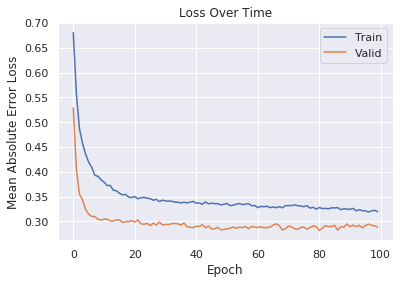

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [35]:
# setting up the final structure 
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states) 

In [36]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [37]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [38]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions']) 

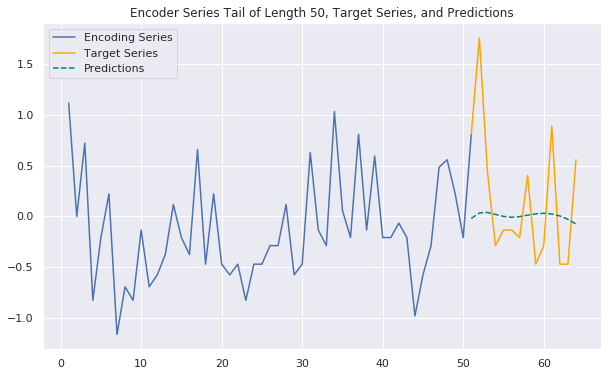

In [40]:
predict_and_plot(encoder_input_data, decoder_target_data, 250)


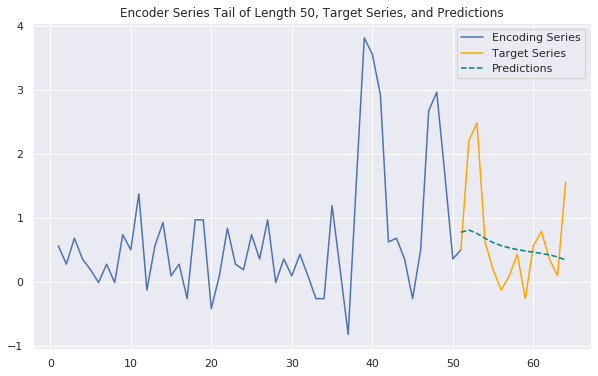

In [41]:
predict_and_plot(encoder_input_data, decoder_target_data, 500)

